### imports

In [96]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier



In [97]:
from types import FunctionType
class DataManager():
    
    def __init__(self):
        self.transformations = {}
       
    
    def add_data_prep(self, func: FunctionType, name=None ,  version='1.0'):
        """functions should get (X_train, X) and return new X"""
        if not name:
            name = func.__name__
        self.transformations[version] = self.transformations.get(version, {})[name] = func
    
    def prep_all_data(self, X_train, X, version='1.0'):
        """returns new X"""
        for func in self.transformations[version].values:
            X = func(X_train,X)
        return X




# first glance

In [98]:
data = pd.read_csv('train.csv')
data.head()

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
0,0,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,...,1.0,safari_15,1.0,Returning_Visitor,False,c_1,118.880094,log202,NaN,0
1,1,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,0.000000,0.200000,0.200000,...,4.0,safari_14,9.0,Returning_Visitor,False,c_3,113.358423,log404,NaN,0
2,2,0.0,0.0,0.0,NaN,NaN,627.5 minutes,627.500000,0.020000,0.050000,...,3.0,browser_3_v17,1.0,Returning_Visitor,True,c_4,121.507695,log202,NaN,0
3,3,0.0,0.0,0.0,0.0 minutes,19.0,154.2166667 minutes,154.216667,0.015789,0.024561,...,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_3,93.747176,log_100,NaN,0
4,4,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,...,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,False,c_3,99.545824,log202,NaN,0


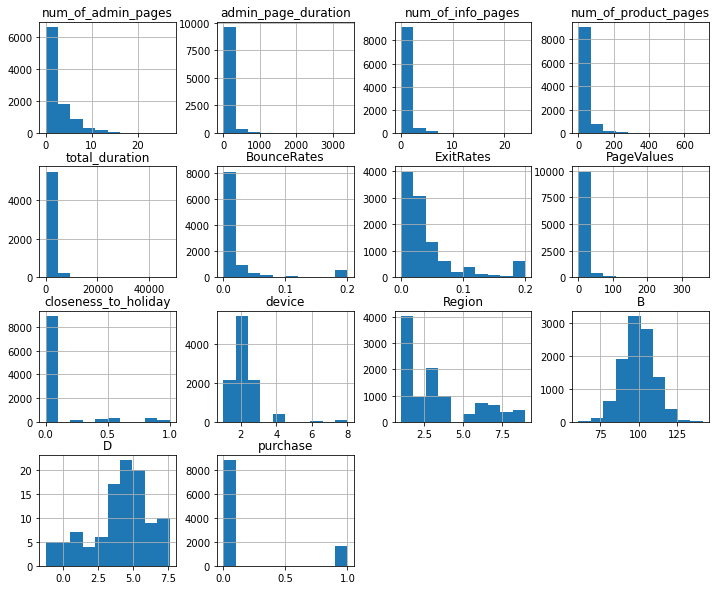

In [99]:
data.iloc[:,1:].hist(figsize=(12,10))
pass

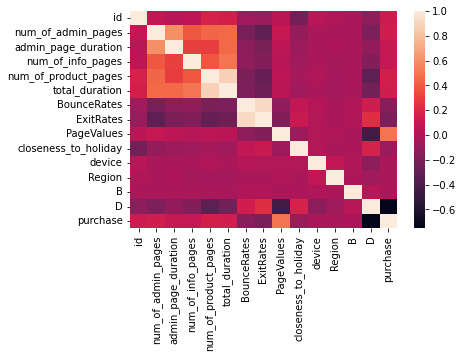

In [100]:
corr = data.corr()
sb.heatmap(corr)
pass

we can see durations are linked

# exploration and preprocessing
1. split data
2. Convert non-numeric features to numeric/dummy
3. Fill out missing values


### split data

In [101]:
Y = data.loc[:,'purchase'] 
X = data.iloc[:, :-1]

X_train, X_val, y_train, y_val = train_test_split(X, Y,test_size=0.8,random_state=23)

print('y value couns:\n',y_train.value_counts(), sep='')
del X, Y
X_train.head(5)


y value couns:
0    1768
1     327
Name: purchase, dtype: int64


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D
2442,2442,0.0,0.000000,0.0,0.0 minutes,5.0,108.0 minutes,108.000000,0.000000,0.080000,...,May,2.0,chrome_90.1.7,3.0,Returning_Visitor,False,c_13,92.047040,log202,NaN
4138,4138,7.0,188.166667,0.0,0.0 minutes,52.0,1089.642857 minutes,1277.809524,0.003509,0.010234,...,May,2.0,browser_5_v19,6.0,Returning_Visitor,True,c_5,95.347227,log8080,NaN
8935,8935,7.0,133.466667,4.0,46.5 minutes,26.0,1357.833333 minutes,NaN,0.000000,0.018487,...,Nov,3.0,chrome_89,9.0,New_Visitor,True,c_2,87.950930,log202,NaN
3648,3648,4.0,259.000000,1.0,42.0 minutes,18.0,401.968254 minutes,NaN,0.000000,0.017105,...,May,1.0,safari_14,3.0,Returning_Visitor,False,c_3,109.345812,log404,NaN
10110,10110,1.0,153.500000,0.0,0.0 minutes,NaN,1002.847222 minutes,NaN,0.000000,0.009524,...,Nov,2.0,chrome_90.1.7,4.0,Returning_Visitor,False,c_2,117.950076,log200,NaN


In [102]:
print("** types: **")
print(X_train.dtypes)

print('\n** label values: **\n',y_train.value_counts())
print(f'purchased sessions are around {int((y_train.loc[y_train == 1].shape[0] / y_train.shape[0]) * 100)}% of all sessions')

** types: **
id                         int64
num_of_admin_pages       float64
admin_page_duration      float64
num_of_info_pages        float64
info_page_duration        object
num_of_product_pages     float64
product_page_duration     object
total_duration           float64
BounceRates              float64
ExitRates                float64
PageValues               float64
closeness_to_holiday     float64
Month                     object
device                   float64
internet_browser          object
Region                   float64
user_type                 object
Weekend                   object
A                         object
B                        float64
C                         object
D                        float64
dtype: object

** label values: **
 0    1768
1     327
Name: purchase, dtype: int64
purchased sessions are around 15% of all sessions


## id
id is probelbly usless for us

In [103]:
def id_prep(X):
    X = X.drop(columns=['id'])
    return X

X_val = id_prep(X_val)
X_train = id_prep(X_train)


### page durations

In [104]:
## convert to numeric
fields = ['info_page_duration', 'product_page_duration']

def page_durations_prep(X):
    for field in fields:
        print(field, 'str structure:', X[field].value_counts().index[0])

        # make sure all durations are in minutes
        print('not minutes count: ', len(X.loc[~X[field].str.contains('minutes').astype('bool'),(field)]))
        print('nan count: ', X[field].isnull().sum())

        # convert to float `type(d)==str ` handles nan values
        X[field] = [float(d.split()[0]) if type(d) is str else np.nan for d in X[field]]

        print('new types:')
        X.dtypes[fields]

    return X

print('train:')
X_train = page_durations_prep(X_train)
print('test:')
X_val = page_durations_prep(X_val)






train:
info_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  58
new types:
product_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  136
new types:
test:
info_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  259
new types:
product_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  485
new types:


In [105]:
## fill missing vlaues
avg_time_in_admin_page = (X_train.admin_page_duration / X_train.num_of_admin_pages).mean()
avg_time_in_info_page = (X_train.info_page_duration / X_train.num_of_info_pages).mean()
avg_time_in_product_page = (X_train.product_page_duration / X_train.num_of_product_pages).mean()

fields.append('admin_page_duration')
avgs = (avg_time_in_info_page, avg_time_in_product_page, avg_time_in_admin_page)

def page_durations_data_prep(X):
    for i, field in enumerate(fields):
        X[field] = X[field].fillna(avgs[i])
    return X

X_train = page_durations_data_prep(X_train)
X_val = page_durations_data_prep(X_val)



### total durations
on the one hand `total duration` has many nan values, on the other hand it is easy enough to calculate it. so we decided to keep it and fill the nans

In [106]:

def total_druation_data_prep(X):
    ## total duration
    computed_durations = X.admin_page_duration + X.info_page_duration + X.product_page_duration
    X.total_duration = X.total_duration.fillna(computed_durations)
    return X

X_train = total_druation_data_prep(X_train)
X_val = total_druation_data_prep(X_val)


### num of page visits

In [107]:
# fill missing values
fields = ('num_of_info_pages', 'num_of_product_pages' ,'num_of_admin_pages' )
avg_num_of_admin_pages = (X_train.admin_page_duration / avg_time_in_admin_page).mean()
avg_num_of_info_pages = (X_train.info_page_duration / avg_time_in_info_page).mean()
avg_num_of_product_pages = (X_train.product_page_duration / avg_time_in_product_page).mean()

avgs = (avg_num_of_info_pages, avg_num_of_product_pages, avg_num_of_admin_pages)

def num_of_visits_data_prep(X: pd.DataFrame):
    for i, field in enumerate(fields):
        X[field] = X[field].fillna(avgs[i])
    return X


X_train = num_of_visits_data_prep(X_train)
X_val = num_of_visits_data_prep(X_val)

### user type
user type has mainly two values, `New_Visitor` and  `Returning_Visitor`.
We wanted to see if we can map it to a binary feature.
For this, we:
1. made sure that `nan` and `other` are very rare
2. made sure there is no strong correlation between `other` and the label or featrue.

In [108]:
# check values
vc = X_train.user_type.value_counts()
nan_count = X_train.user_type.isnull().sum()
print('original user type values:\n', vc)
print('nan count        :', nan_count)
print('\n`other` categoryh is only ', f"{round(vc['Other'] / X_train.shape[0] * 100, 2)}%", 'of the data')
print('`Returning_Visitor` categoryh is ', f"{round(vc['Returning_Visitor'] / X_train.shape[0] * 100, 2)}%", 'of the data')
print('nan values are only ', f"{round(nan_count / X_train.shape[0] * 100, 2)}%", 'of the data')



original user type values:
 Returning_Visitor    1781
New_Visitor           290
Other                  17
Name: user_type, dtype: int64
nan count        : 7

`other` categoryh is only  0.81% of the data
`Returning_Visitor` categoryh is  85.01% of the data
nan values are only  0.33% of the data


explore correlations betwenn user type and other features

In [109]:
X_train_user_dummy = pd.get_dummies(X_train,columns=['user_type'], prefix_sep='_dmy_', drop_first=False)

<AxesSubplot:>

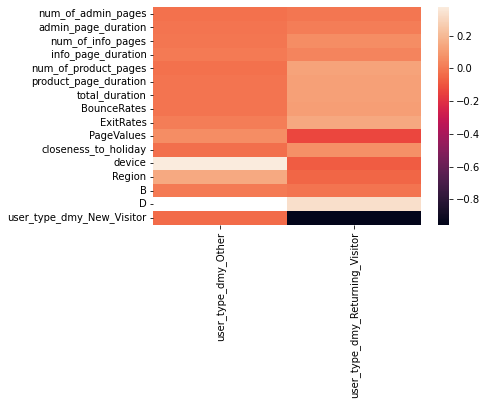

In [110]:
sb.heatmap(X_train_user_dummy.corr()[16:19].T[:16])

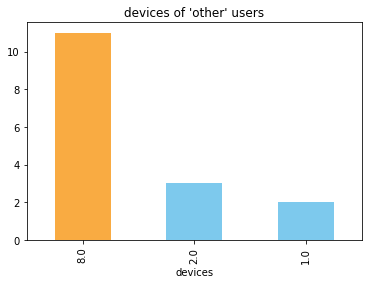

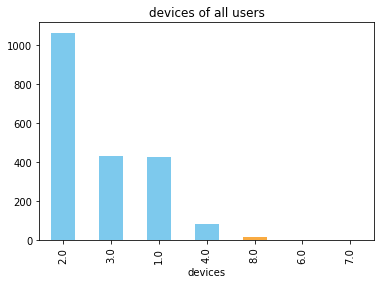

In [111]:

X_train.loc[X_train.user_type == 'Other', ('device')].value_counts().plot.bar(color=['#F9AB42']+['#7DC9ED']*2,
 title="devices of 'other' users", xlabel='devices')
plt.show()
devices_all = X_train.device.value_counts()
i = np.where(devices_all.index == 8.0)[0][0]
clrs = ['#7DC9ED']*7
clrs[i] = "#F9AB42"
devices_all.plot.bar(color=clrs,
 title="devices of all users", xlabel='devices')
plt.show()

### user_type - conclusion
two interesting correlartion here:  
a. `device` and `Other`:   
altough device 8 is very rare, almost all of device 8 sessions are `other`.  
It may mean that device 8 has some bug when collecing `user_type` data. However for our purpose it is not helpful (We were looking for a way to turn "other" to one of the other two.)  
b. `D`. but since `D` is mostly missing values, We shall treat `user type` as binary: only new users (0) and returing users (1)

In [112]:
#  map 'Returning_Visitor' , missing value and  'other' to 1, and New_Visitor to 0
RETURNING ='Returning_Visitor'

def user_type_data_prep(X):
    X.user_type = [1 if u_type == RETURNING else 0 for u_type in X.user_type] 
    return X

X_train = user_type_data_prep(X_train)
X_val = user_type_data_prep(X_val)




## D
d's seem to have mostly nan values
If it's lower than 10%, we will remove it altogether

In [113]:
valid_ds = X_train.loc[~np.isnan(X_train.D)]
print('only', str((valid_ds.shape[0] / X_train.shape[0]) * 100)[:3], "% of D's have values")

def d_data_prep(X):
    # remove D feature        
    return X.drop(columns=('D'))
del valid_ds

X_train = d_data_prep(X_train)
X_val = d_data_prep(X_val)


only 0.9 % of D's have values


## Bounce rate,  Exit rate, Page value

In [114]:
print('BounceRates nan count:', X_train.BounceRates.isnull().sum())
print('ExitRates nan count:', X_train.ExitRates.isnull().sum())
print('page values nan count:', X_train.PageValues.isnull().sum())

def rates_page_value_data_prep(X):
    global X_train
    # so little nan values - lets fill with mean
    X.BounceRates = X.BounceRates.fillna(X_train.BounceRates.mean())
    X.ExitRates = X.ExitRates.fillna(X_train.ExitRates.mean())
    X.PageValues = X.PageValues.fillna(X_train.PageValues.mean())
    return X


X_train = rates_page_value_data_prep(X_train)
X_val= rates_page_value_data_prep(X_val)


BounceRates nan count: 5
ExitRates nan count: 3
page values nan count: 6


## closeness to holiday

closeness_to_holiday nan caount: 85


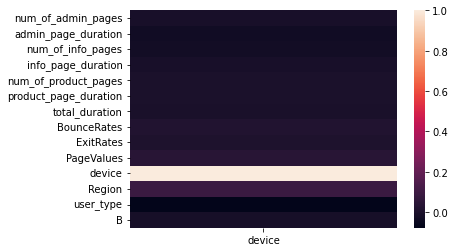

In [115]:
print('closeness_to_holiday nan caount:', X_train.closeness_to_holiday.isnull().sum())
corr = X_train.corr()
sb.heatmap(corr.iloc[11:12].T[corr.columns != 'closeness_to_holiday'])
pass



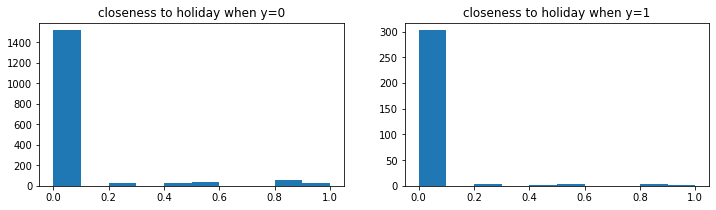

In [116]:

figure, axes = plt.subplots(1,2)
figure.set_size_inches((12,3))
for axe, yi in zip(axes, (0,1)):
    axe.hist(X_train.closeness_to_holiday[y_train ==yi])
    axe.set_title(f'closeness to holiday when y={yi}')
plt.show()



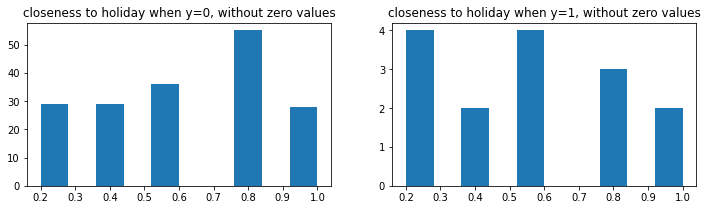

In [117]:
figure, axes = plt.subplots(1,2)
figure.set_size_inches((12,3))
for axe, yi in zip(axes, (0,1)):
    axe.hist(X_train.closeness_to_holiday[(y_train ==yi) & X_train.closeness_to_holiday != 0.0])
    axe.set_title(f'closeness to holiday when y={yi}, without zero values')
plt.show()


we didnt found any intersting correlataions, using mean

In [118]:
def closeness_data_prep(X):
    global X_train
    X.closeness_to_holiday = X.closeness_to_holiday.fillna(X_train.closeness_to_holiday.mean())
    return X

X_train = closeness_data_prep(X_train)
X_val = closeness_data_prep(X_val)


## Device

In [119]:
X_train.device.value_counts()


2.0    1063
3.0     432
1.0     424
4.0      84
8.0      14
6.0       2
7.0       1
Name: device, dtype: int64

In [120]:

mapper = {1.0: '1', 2.0: '2', 3.0: '3', 'Default': 'other'}
def make_dummy_device(X: pd.DataFrame):
    X.device = [mapper.get(d, mapper['Default']) for d in X.device]    
    return pd.get_dummies(data=X, columns=['device'], drop_first=False, prefix_sep='_dmy_')
    
X_train = make_dummy_device(X_train)
X_val = make_dummy_device(X_val)

In [121]:
X_train.columns

Index(['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',
       'info_page_duration', 'num_of_product_pages', 'product_page_duration',
       'total_duration', 'BounceRates', 'ExitRates', 'PageValues',
       'closeness_to_holiday', 'Month', 'internet_browser', 'Region',
       'user_type', 'Weekend', 'A', 'B', 'C', 'device_dmy_1', 'device_dmy_2',
       'device_dmy_3', 'device_dmy_other'],
      dtype='object')

In [122]:
X_train.C.value_counts()

log200     378
log404     363
log_100    357
log202     341
log8080    332
log400     320
Name: C, dtype: int64

In [123]:

def make_dummy_C(X: pd.DataFrame):
    def extract_num(s):   
        if s is np.nan:
             return s
        for indx, chr in enumerate(s):
            if str.isdigit(chr):
                break
        return s[indx:]
    X.C = [extract_num(c) for c in X.C]

    return pd.get_dummies(data=X, columns=['C'], drop_first=False, prefix_sep='_dmy_')
    

X_train = make_dummy_C(X_train)
X_val = make_dummy_C(X_val)

## weekand

In [124]:
X_train.Weekend.value_counts()

False    1588
True      502
Name: Weekend, dtype: int64

In [125]:

def weekend_data_prep(X):
    X.Weekend = [1 if w else 0 for w in X.Weekend]
    return X

X_train = weekend_data_prep(X_train)
X_val = weekend_data_prep(X_val)
X_train.Weekend.value_counts()



0    1588
1     507
Name: Weekend, dtype: int64

## B

In [126]:
print("B nan count:", X_train.B.isnull().sum())
def b_data_prep(X):
    global X_train
    X.B = X.B.fillna(X_train.B.mean())
    return X

X_train = b_data_prep(X_train)
X_val = b_data_prep(X_val)

print("B nan count after filling - train:", X_train.B.isnull().sum())
print("B nan count after filling - test:", X_val.B.isnull().sum())




B nan count: 6
B nan count after filling - train: 0
B nan count after filling - test: 0


## browser

In [127]:
X_train.internet_browser = X_train.internet_browser.str.replace('\d+', '')
X_train['internet_browser'] = X_train['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')

X_val.internet_browser = X_val.internet_browser.str.replace('\d+', '')
X_val['internet_browser'] = X_val['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')

print(X_train.internet_browser.value_counts())

# corr = X_train.corr()
# sb.heatmap(corr.iloc[8:15].T[corr.columns != 'internet_browser'])


# X_train.internet_browser = ['Other' if i == 'nan' else X_train.internet_browser]


chrome     1286
safari      380
browser     192
nan         123
edge        114
Name: internet_browser, dtype: int64


C:\Users\itayz\AppData\Local\Temp\ipykernel_18176\3972795123.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  X_train.internet_browser = X_train.internet_browser.str.replace('\d+', '')
C:\Users\itayz\AppData\Local\Temp\ipykernel_18176\3972795123.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  X_val.internet_browser = X_val.internet_browser.str.replace('\d+', '')


In [128]:
X_train_browser_dummy = pd.get_dummies(X_train,columns=['internet_browser'],drop_first=False, prefix_sep='_dmy_')

<AxesSubplot:>

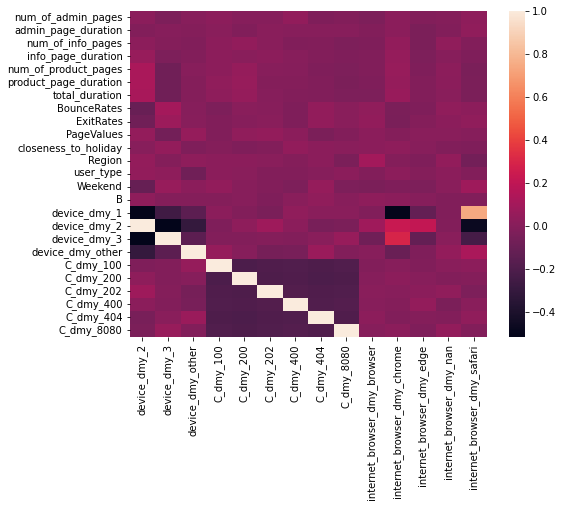

In [129]:
corr = X_train_browser_dummy.corr()
plt.figure(figsize=(8,6))
sb.heatmap(corr.iloc[16:].T[~corr.columns.str.startswith('internet_browser')])


In [130]:
X_train

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,device_dmy_1,device_dmy_2,device_dmy_3,device_dmy_other,C_dmy_100,C_dmy_200,C_dmy_202,C_dmy_400,C_dmy_404,C_dmy_8080
2442,0.0,0.000000,0.00000,0.00,5.000000,108.000000,108.000000,0.000000,0.080000,0.000000,...,0,1,0,0,0,0,1,0,0,0
4138,7.0,188.166667,0.00000,0.00,52.000000,1089.642857,1277.809524,0.003509,0.010234,20.117930,...,0,1,0,0,0,0,0,0,0,1
8935,7.0,133.466667,4.00000,46.50,26.000000,1357.833333,1537.800000,0.000000,0.018487,18.269401,...,0,0,1,0,0,0,1,0,0,0
3648,4.0,259.000000,1.00000,42.00,18.000000,401.968254,702.968254,0.000000,0.017105,0.000000,...,1,0,0,0,0,0,0,0,1,0
10110,1.0,153.500000,0.00000,0.00,30.986384,1002.847222,1156.347222,0.000000,0.009524,41.134331,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,0.0,0.000000,0.00000,0.00,2.000000,12.000000,12.000000,0.000000,0.100000,0.000000,...,0,1,0,0,0,1,0,0,0,0
9704,1.0,10.500000,3.00000,264.75,30.986384,38.050190,10320.007560,0.005025,0.023180,0.000000,...,0,1,0,0,0,0,0,0,0,1
10185,0.0,0.000000,0.00000,0.00,9.000000,891.500000,891.500000,0.000000,0.012500,0.000000,...,1,0,0,0,0,0,0,0,0,1
9256,7.0,104.450000,0.00000,0.00,63.000000,1242.661699,1347.111699,0.011912,0.026918,0.000000,...,1,0,0,0,0,0,0,0,1,0


### fill na - browser
we can see there's a link between device and browswer, device 1 linked to safari (probelbly iphone/mac?) and devices 2 and 3 linked to chrome.

In [131]:

def browser_data_prep(X: pd.DataFrame):
    global X_train
    X = pd.get_dummies(X,columns=['internet_browser'],drop_first=False, prefix_sep='_dmy_')    


    # device 1 means safari
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_1 > 0), ('internet_browser_dmy_safari',)] = 1

    # device 2/3 means chrome
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_2 + X.device_dmy_3  > 0), ('internet_browser_dmy_chrome',)] = 1

    print(X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_other == 1)].shape[0], ' nan values left. we shall fill it with chrome - chrome is the most common')

    # # fill with chrome
    X.loc[(X.internet_browser_dmy_nan == 1) & (X.device_dmy_other == 1), 'internet_browser_dmy_chrome'] = 1

    # make sure no nan left 
    print(X.loc[(X.internet_browser_dmy_nan == 1) & ((X.internet_browser_dmy_chrome + X.internet_browser_dmy_safari) < 1)].shape[0], ' nan values left.')

    # drop nan dummy
    return X.drop(columns=['internet_browser_dmy_nan'])

X_train = browser_data_prep(X_train)
X_val = browser_data_prep(X_val)

    

16  nan values left. we shall fill it with chrome - chrome is the most common
0  nan values left.
42  nan values left. we shall fill it with chrome - chrome is the most common
0  nan values left.


## month
divide to 4 yearly quarters

In [132]:
Month = {'JAN':1, 'Feb':1, 'Mar':1, 'APR':2, 'May':2, 'June':2, 'Jul':3, 'Aug':3, 'Sep':3, 'Oct':4, 'Nov':4, 'Dec':4}
def month_data_prep(X):
     X.Month = X.Month.map(Month)
     X.Month = X.Month.fillna(X_train.Month.median())
     return X

X_train = month_data_prep(X_train)
X_val = month_data_prep(X_val)
X_train.Month.value_counts()


4.0    895
2.0    621
1.0    338
3.0    241
Name: Month, dtype: int64

## Region

In [133]:
print(X_train.Region.value_counts())
print('nan count before:', X_train.Region.isnull().sum())

# fill nan with median
def region_data_prep(X_t, X: pd.DataFrame):
    train_median = np.median(X_t.Region[~X_t.Region.isnull()])
    X.Region = X.Region.fillna(train_median)
    return X

c = X_train.copy()
c = region_data_prep(X_train, c)
X_train = region_data_prep(X_train, X_train)
X_val = region_data_prep(X_train, X_val)

print('nan count after:', X_train.Region.isnull().sum())



1.0    795
3.0    398
2.0    205
4.0    189
7.0    155
6.0    131
9.0     96
8.0     76
5.0     48
Name: Region, dtype: int64
nan count before: 2
nan count after: 0


## A feature

In [134]:
t1 = X_train.A[[str(a).split('_').__len__() == 2 for a in X_train.A]]
t2 = X_train.A[[str(a).split('_').__len__() > 2 for a in X_train.A]]
print('type 1:',t1.iloc[0:5])
print('count', t1.shape[0])

print('\ntype 2:\n', t2.iloc[0:5])
print('count', t2.shape[0])


type 1: 2442     c_13
4138      c_5
8935      c_2
3648      c_3
10110     c_2
Name: A, dtype: object
count 1915

type 2:
 3969    c_20_74
4926    c_20_14
4351    c_20_61
5329    c_20_47
5213     c_20_4
Name: A, dtype: object
count 34


In [135]:
print('type 1 describe:')
pd.Series([float(str(a).split('_')[1]) if str(a).split('_').__len__() == 2 else np.nan for a in X_train.A]).describe()


type 1 describe:


count    1915.000000
mean        3.800522
std         3.485887
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        19.000000
dtype: float64

since max is now 19, seems reasonble to use the `c_xx_??` type as `xx`  
this way we can transfer all using `.split('_')[1]`

<AxesSubplot:>

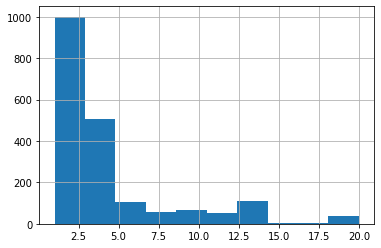

In [136]:
X_train.A = [np.nan if a is np.nan else float(str(a).split('_')[1]) for a in X_train.A]
X_val.A = [np.nan if a is np.nan else float(str(a).split('_')[1]) for a in X_val.A]

X_train.A.hist()


In [137]:
print('nan count:', X_train.A.isna().sum())

nan count: 146


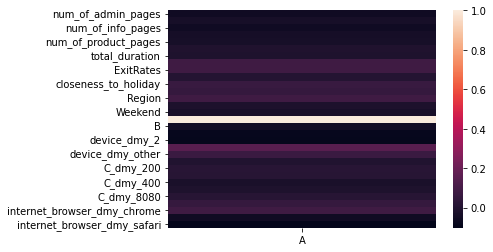

In [138]:
corr = X_train.corr()
sb.heatmap(corr[corr.columns == 'A'].T)
pass

since the distribution decreases left to rihgt - we will fill na with median.

nan count after filling - train: 0
nan count after filling - test: 0


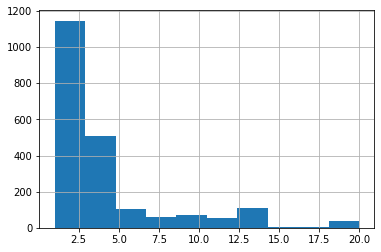

In [139]:
def a_data_prep(X_t, X):
    train_median = np.median(X_t.A[~X_t.A.isnull()])
    X.A = X.A.fillna(train_median)
    #X.A[X.A.isnull()] = train_median
    return X

X_train = a_data_prep(X_train, X_train)
X_val = a_data_prep(X_train, X_val)

X_train.A.hist()

print('nan count after filling - train:', X_train.A.isnull().sum())
print('nan count after filling - test:', X_val.A.isnull().sum())


In [140]:
X_val.A

8599      2.0
4646     13.0
5836      5.0
2476      6.0
8509     13.0
         ... 
8127      2.0
5478      3.0
5310     13.0
2254      1.0
10429     7.0
Name: A, Length: 8384, dtype: float64

# Outlier removal and normalization

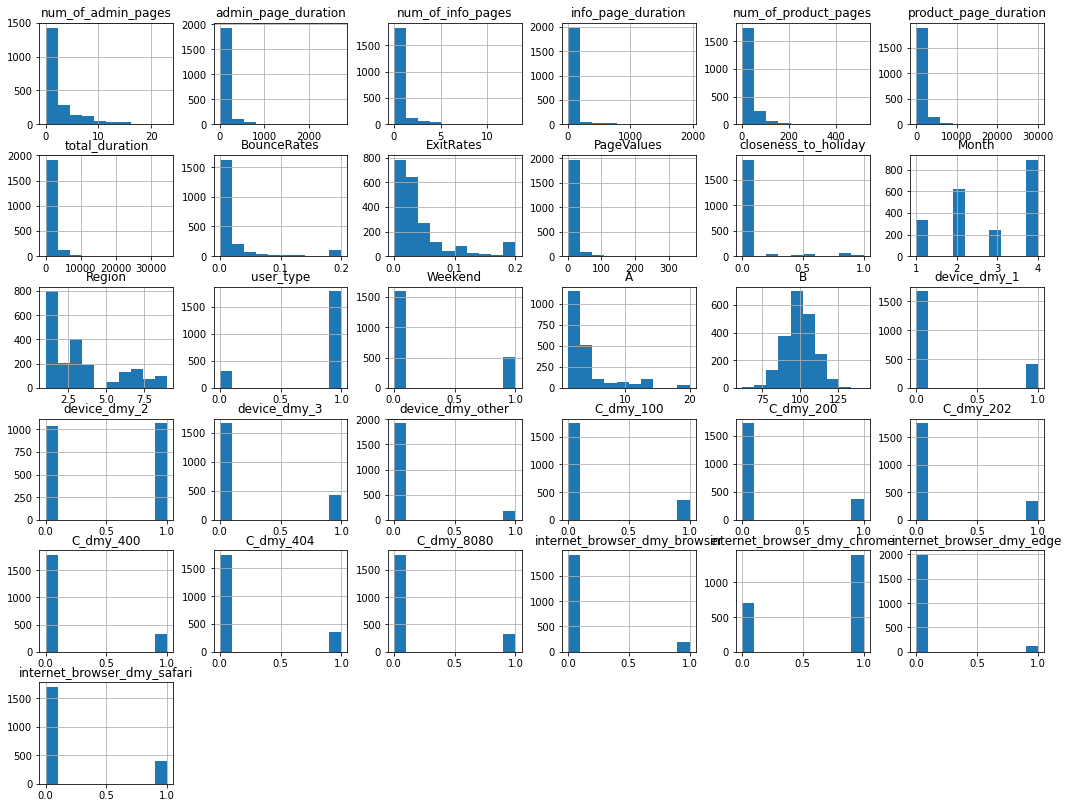

In [141]:
X_train.hist(figsize=(18,14))

pass

In [142]:
des = X_train.describe()
std = des.loc[des.index == 'std']
std.iloc[:,0:20]


,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,Region,user_type,Weekend,A,B,device_dmy_1,device_dmy_2,device_dmy_3
std,3.425202,180.54421,1.191541,138.033195,44.799489,2016.900234,2169.22172,0.046948,0.047094,22.738759,0.196322,1.154465,2.460814,0.35704,0.428399,3.94651,9.93346,0.401875,0.500065,0.404676


In [143]:
std.iloc[:,20:]


,device_dmy_other,C_dmy_100,C_dmy_200,C_dmy_202,C_dmy_400,C_dmy_404,C_dmy_8080,internet_browser_dmy_browser,internet_browser_dmy_chrome,internet_browser_dmy_edge,internet_browser_dmy_safari
std,0.277468,0.376079,0.384637,0.369242,0.359827,0.378571,0.365271,0.288596,0.47296,0.226889,0.393503


In [144]:
del std, des 

In [145]:
duration_treshold = 30
print("users who purchesed after less then 30 seconds:", y_train[X_train['total_duration'] < duration_treshold].sum())
print(f'number of users under {duration_treshold} seconds:', X_train.loc[X_train['total_duration'] < duration_treshold].shape[0])

users who purchesed after less then 30 seconds: 1
number of users under 30 seconds: 161


In [146]:
X_train

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,C_dmy_100,C_dmy_200,C_dmy_202,C_dmy_400,C_dmy_404,C_dmy_8080,internet_browser_dmy_browser,internet_browser_dmy_chrome,internet_browser_dmy_edge,internet_browser_dmy_safari
2442,0.0,0.000000,0.00000,0.00,5.000000,108.000000,108.000000,0.000000,0.080000,0.000000,...,0,0,1,0,0,0,0,1,0,0
4138,7.0,188.166667,0.00000,0.00,52.000000,1089.642857,1277.809524,0.003509,0.010234,20.117930,...,0,0,0,0,0,1,1,0,0,0
8935,7.0,133.466667,4.00000,46.50,26.000000,1357.833333,1537.800000,0.000000,0.018487,18.269401,...,0,0,1,0,0,0,0,1,0,0
3648,4.0,259.000000,1.00000,42.00,18.000000,401.968254,702.968254,0.000000,0.017105,0.000000,...,0,0,0,0,1,0,0,0,0,1
10110,1.0,153.500000,0.00000,0.00,30.986384,1002.847222,1156.347222,0.000000,0.009524,41.134331,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,0.0,0.000000,0.00000,0.00,2.000000,12.000000,12.000000,0.000000,0.100000,0.000000,...,0,1,0,0,0,0,1,0,0,0
9704,1.0,10.500000,3.00000,264.75,30.986384,38.050190,10320.007560,0.005025,0.023180,0.000000,...,0,0,0,0,0,1,0,1,0,0
10185,0.0,0.000000,0.00000,0.00,9.000000,891.500000,891.500000,0.000000,0.012500,0.000000,...,0,0,0,0,0,1,0,0,0,1
9256,7.0,104.450000,0.00000,0.00,63.000000,1242.661699,1347.111699,0.011912,0.026918,0.000000,...,0,0,0,0,1,0,0,0,0,1


### standarization

In [147]:
noraml_features = ['B']
dummy_features = [f for f in X_train.columns if ('_dmy_' in f)]
X_train.loc[:,~X_train.columns.isin(dummy_features + noraml_features)]

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,Region,user_type,Weekend,A
2442,0.0,0.000000,0.00000,0.00,5.000000,108.000000,108.000000,0.000000,0.080000,0.000000,0.000000,2.0,3.0,1,0,13.0
4138,7.0,188.166667,0.00000,0.00,52.000000,1089.642857,1277.809524,0.003509,0.010234,20.117930,0.000000,2.0,6.0,1,1,5.0
8935,7.0,133.466667,4.00000,46.50,26.000000,1357.833333,1537.800000,0.000000,0.018487,18.269401,0.000000,4.0,9.0,0,1,2.0
3648,4.0,259.000000,1.00000,42.00,18.000000,401.968254,702.968254,0.000000,0.017105,0.000000,0.059403,2.0,3.0,1,0,3.0
10110,1.0,153.500000,0.00000,0.00,30.986384,1002.847222,1156.347222,0.000000,0.009524,41.134331,0.000000,4.0,4.0,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,0.0,0.000000,0.00000,0.00,2.000000,12.000000,12.000000,0.000000,0.100000,0.000000,0.000000,3.0,2.0,1,0,6.0
9704,1.0,10.500000,3.00000,264.75,30.986384,38.050190,10320.007560,0.005025,0.023180,0.000000,0.000000,4.0,1.0,1,0,2.0
10185,0.0,0.000000,0.00000,0.00,9.000000,891.500000,891.500000,0.000000,0.012500,0.000000,0.000000,4.0,1.0,1,0,2.0
9256,7.0,104.450000,0.00000,0.00,63.000000,1242.661699,1347.111699,0.011912,0.026918,0.000000,0.000000,4.0,8.0,1,0,2.0


In [148]:
noraml_features = ['B']
dummy_features = [f for f in X_train.columns if ('_dmy_' in f)]

def standarization(X):
    # standard_scaler = StandardScaler()
    minmax_scalar = MinMaxScaler()
    # standard_scaler.fit(X_train.loc[:,noraml_features])
    # minmax_mask = ~X.columns.isin(dummy_features + noraml_features)
    minmax_mask = ~X.columns.isin(dummy_features)
    minmax_scalar.fit(X.loc[:,minmax_mask])

    # X.loc[:,noraml_features] = standard_scaler.transform(X.loc[:,noraml_features])
    X.loc[:,minmax_mask] = minmax_scalar.transform(X.loc[:,minmax_mask])

    return X 

X_train = standarization(X_train)
X_val = standarization(X_val)
X_train

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,C_dmy_100,C_dmy_200,C_dmy_202,C_dmy_400,C_dmy_404,C_dmy_8080,internet_browser_dmy_browser,internet_browser_dmy_chrome,internet_browser_dmy_edge,internet_browser_dmy_safari
2442,0.000000,0.000000,0.000000,0.000000,0.009671,0.003604,0.003123,0.000000,0.400000,0.000000,...,0,0,1,0,0,0,0,1,0,0
4138,0.304348,0.069166,0.000000,0.000000,0.100580,0.036357,0.036956,0.017544,0.051170,0.055611,...,0,0,0,0,0,1,1,0,0,0
8935,0.304348,0.049060,0.307692,0.023856,0.050290,0.045306,0.044475,0.000000,0.092437,0.050501,...,0,0,1,0,0,0,0,1,0,0
3648,0.173913,0.095203,0.076923,0.021548,0.034816,0.013412,0.020331,0.000000,0.085526,0.000000,...,0,0,0,0,1,0,0,0,0,1
10110,0.043478,0.056423,0.000000,0.000000,0.059935,0.033461,0.033443,0.000000,0.047619,0.113705,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,0.000000,0.000000,0.000000,0.000000,0.003868,0.000400,0.000347,0.000000,0.500000,0.000000,...,0,1,0,0,0,0,1,0,0,0
9704,0.043478,0.003860,0.230769,0.135827,0.059935,0.001270,0.298465,0.025126,0.115901,0.000000,...,0,0,0,0,0,1,0,1,0,0
10185,0.000000,0.000000,0.000000,0.000000,0.017408,0.029746,0.025783,0.000000,0.062500,0.000000,...,0,0,0,0,0,1,0,0,0,1
9256,0.304348,0.038394,0.000000,0.000000,0.121857,0.041463,0.038960,0.059559,0.134590,0.000000,...,0,0,0,0,1,0,0,0,0,1


In [149]:
def validate_data_prep(X):
    print(X.isna().sum().max() == 0)
    print(np.all(X_train.max() <= 1))
    print(np.all(X_train.min() >= 0))

validate_data_prep(X_train)
validate_data_prep(X_val)

True
True
True
True
True
True


# Models !

generic kfold validation function

In [162]:
# def validate_model(data, labels, model, model_name):

def validate_model(all_data, all_labels, model, model_name, num_folds=10):
    # 0.5 auc line
    baseline = [0,1]
    plt.plot(baseline, baseline, color='black', linestyle=':')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    


    # fpr would be the x axis. this is to calc mean auc between all iterations
    fpr_all_values = np.linspace(0,1,100) 
    tpr_sum = np.array([0.0]*100) 
    auc_sum = 0

    for train_mask, val_mask in KFold(num_folds, shuffle=True, random_state=13).split(X=all_data, y=all_labels):
        xt = all_data.iloc[train_mask] # x train
        xv = all_data.iloc[val_mask] # x validation
        yt = all_labels.iloc[train_mask] # y train
        yv = all_labels.iloc[val_mask] # y validation
        
        model.fit(xt, yt)

        fpr, tpr, thresholds = roc_curve(yv, model.predict_proba(xv)[:,1])
        plt.plot(fpr, tpr, color='lightpink')
        tpr_sum += np.interp(fpr_all_values, fpr, tpr)
        auc_sum += roc_auc_score(yv, model.predict_proba(xv)[:,1])
            

    plt.plot(fpr_all_values, tpr_sum / num_folds , color='darkred')
    plt.title(f'{model_name} result. AUC={round(auc_sum / num_folds, 5)}')
    



generic auc plotting

In [220]:
def plot_auc(model_class, arg_name:str, arg_values:list, other_args:dict, xt, xv, yt, yv):
    """ for example knn: plot_auc()"""
    d = other_args | {} 
    scores = []
    for value in arg_values:
        d[arg_name] = value
        model = model_class(**d)        
        model.fit(xt, yt)
        auc = max(
            roc_auc_score(y_train, model.predict_proba(X_train)[:,i])
            for i in (0,1))
        scores.append(auc)
    
    plt.plot(arg_values, scores)
    plt.ylabel('AUC score')
    plt.xlabel(arg_name)
    plt.title(f'auc scores for {model_class.__name__}')
                
                

combine all data

In [151]:
all_data = pd.concat([X_train, X_val])
all_labels = pd.concat([y_train, y_val])

## logistic regression

In [152]:
model = LogisticRegression(C=10)

model.fit(X_train, y_train)
fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
auc = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
auc


c:\Users\itayz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8757973902334399

In [216]:
# train
#Cs = [1,10,100,500,1000]
Cs = [1,1000]

for c in Cs:
    log_reg =  LogisticRegression(C=c)
    log_reg.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(X_train)[:,1])
    auc = max(roc_auc_score(y_train, log_reg.predict_proba(X_train)[:,1])
    print('C = ', c)
    print('AUC = ', auc)
    print('\n')



C =  1
AUC =  0.8439173481672132


C =  1000
AUC =  0.8824809387410575




c:\Users\itayz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## K-nn 
 

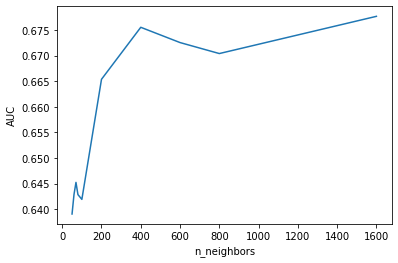

In [193]:

ns = [50,60,70,80,100,200,400,600,800,1200,1600,2000]

plot_auc(KNeighborsClassifier, 'n_neighbors',
 ns, X_train, X_val, y_train, y_val)
# scores = []
# for n in ns:
#     model = KNeighborsClassifier(n_neighbors=n)
#     model.fit(X_train, y_train)
#     scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))

# plt.plot(ns, scores)
# plt.ylabel('auc')
# plt.xlabel('number of neighbors')

# plt.show()



seems the right number of neighbors would be around 400. we'll let `GridSearch` decide the exact value

In [155]:
ns = [i for i in range(300,500,10)]
cross_valudation = GridSearchCV(estimator=model, param_grid={'n_neighbors': ns}, scoring='roc_auc')
cross_valudation.fit(X_train, y_train)
best_n = cross_valudation.best_estimator_.n_neighbors

print("chosen number of neighbors:", best_n)
model = KNeighborsClassifier(n_neighbors=best_n)



chosen number of neighbors: 340


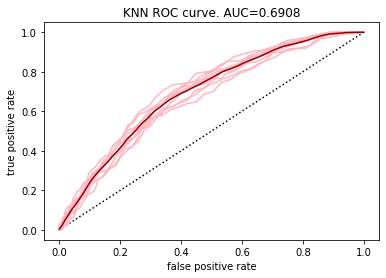

In [163]:
validate_model(all_data, all_labels, model, 'KNN')

the mean of a 340 cluster giver 0.67 auc

# Multi-Layer Perceptron

In [230]:
model = MLPClassifier(hidden_layer_sizes=(166,), max_iter=225, solver='sgd',verbose=False,
                        tol=10**-8,random_state=34, learning_rate_init=0.1, alpha=)
model.fit(X_train, y_train)
auc1 = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
auc2 = roc_auc_score(y_val, model.predict_proba(X_val)[:,0])
max(auc1, auc2)


0.679767092559126

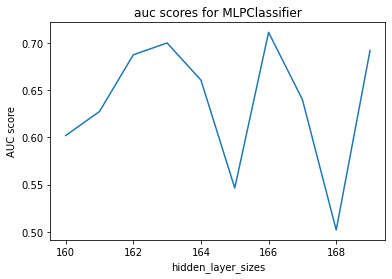

In [225]:
args = {'max_iter':225, 'solver':'sgd','verbose':False,
                        'tol':10**-8,'random_state':34, 'learning_rate_init':0.1, 'alpha':100}
hidden_layers_values = [(i,) for i in range(160,170,1)]

model.fit(X_train, y_train)
plot_auc(MLPClassifier,'hidden_layer_sizes', hidden_layers_values, args, 
X_train, X_val, y_train, y_val)



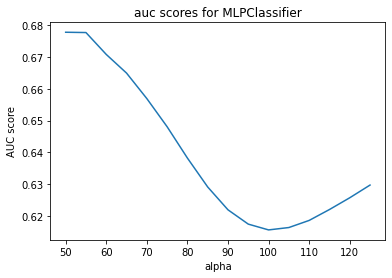

In [238]:
args = {'hidden_layer_sizes':(100,),'max_iter':225, 'solver':'sgd','verbose':False,
                        'tol':10**-8,'random_state':34, 'learning_rate_init':0.1}
alphas = [i for i in range(50,130,5)]

plot_auc(MLPClassifier,'alpha', alphas, args, 
X_train, X_val, y_train, y_val)

